In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import sys
from copy import deepcopy
import warnings

from pathlib import Path
import matplotlib.pyplot as plt
import napari

import scanreader

import pandas as pd
import numpy as np
import dask.array as da
import numpy as np
try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import mesmerize_core as mc
from mesmerize_core.caiman_extensions.cnmf import cnmf_cache

from caiman.motion_correction import high_pass_filter_space
from caiman.summary_images import correlation_pnr


if os.name == "nt":
    # disable the cache on windows
    cnmf_cache.set_maxsize(0)

sys.path.append("../../scanreader/")
warnings.filterwarnings("ignore")
os.environ["CONDA_PREFIX_1"] = ""
os.environ["WGPU_BACKEND"]="gl"

pd.options.display.max_colwidth = 120

## Functions 
def clear_zeros(_scan, rmz_threshold=1e-5):
    non_zero_rows = ~np.all(np.abs(_scan) < rmz_threshold, axis=(0, 2))
    non_zero_cols = ~np.all(np.abs(_scan) < rmz_threshold, axis=(0, 1))
    cleaned = _scan[:, non_zero_rows, :]
    return cleaned[:, :, non_zero_cols]

def trim_scan(scan, amounts_x):
    new_slice_x = [slice(s.start + amounts_x[0], s.stop - amounts_x[1]) for s in scan.fields[0].output_xslices]
    return [i for s in new_slice_x for i in range(s.start, s.stop)]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024-08-16 14:20:18.948616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 14:20:18.948652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 14:20:18.949065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
parent = Path('/home/mbo/caiman_data/high_res')

mc.set_parent_raw_data_path(parent / 'final')
process_path = mc.get_parent_raw_data_path()
old_batch = mc.get_parent_raw_data_path().joinpath("batch/reg")
batch_path = mc.get_parent_raw_data_path().joinpath("batch/cnmf")
save_path = mc.get_parent_raw_data_path().joinpath("results")
raw = [x for x in parent.glob("*.tif*")]
movie_names = [x for x in process_path.glob("*.tif*")]

In [9]:
reader = scanreader.read_scan(str(raw[0]), join_contiguous=True)

In [3]:
# create a new batch
try:
    df = mc.create_batch(batch_path)
except FileExistsError:
    df = mc.load_batch(batch_path)

df_old = mc.load_batch(old_batch)

In [15]:
# some params for CNMF
params_cnmf = {
    'main': # indicates that these are the "main" params for the CNMF algo
        {
            'fr': reader.fps, # framerate, very important!
            'p': 2,
            'nb': 2,
            'merge_thr': 0.80,
            'rf': 15,
            'stride': 6, # "stride" for cnmf, "strides" for mcorr
            'K': 4,
            'gSig': [4, 4],
            'ssub': 1,
            'tsub': 1,
            'method_init': 'greedy_roi',
            'min_SNR': 2.0,
            'rval_thr': 0.7,
            'use_cnn': False,
            'min_cnn_thr': 0.8,
            'decay_time': 0.4,
        },
    'refit': True, # If `True`, run a second iteration of CNMF
}

In [25]:
good_mcorr_index = 5

# add a batch item
df.caiman.add_item(
    algo='cnmf', # algo is cnmf
    input_movie_path=df_old.iloc[good_mcorr_index],  # use mcorr output from a completed batch item
    params=params_cnmf,
    item_name=df_old.iloc[good_mcorr_index]["item_name"], # use the same item name
)

In [26]:
index = -1  # most recently added item
df.iloc[index].caiman.run()

2024-08-16 14:04:37.943493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 14:04:37.943523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 14:04:37.943902: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                           extracted_plane_1
input_movie_path    8a21cd28-8f0a-4796-8847-8f026daedc47/8a21cd28-...
params              {'main': {'fr': 9.60806, 'p': 2, 'nb': 2, 'mer...
outputs                                                          None
added_time                                        2024-08-16T14:04:28
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             455f1a04-d06e-447b-b73f-64ff9affd62d
Name: 0, dtype: object
With params:{'main': {'fr': 9.60806, 'p': 2, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (4, 4), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
In setting CNMFParams, non-pathed parameters were used; this is deprecated. In some future version of Caiman, allow_legacy will default to False (and eventually will be removed)


making memmap


The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


performing CNMF
fitting images
refitting
performing eval


<Popen: returncode: 0 args: '/home/mbo/caiman_data/high_res/final/batch/455f...>

In [4]:
df = df.caiman.reload_from_disk()
df.outputs

0    {'mean-projection-path': 455f1a04-d06e-447b-b73f-64ff9affd62d/455f1a04-d06e-447b-b73f-64ff9affd62d_mean_projection.n...
Name: outputs, dtype: object

In [5]:
index = -1  # index of the cnmf item, last item in the dataframe

# temporal components
temporal = df.iloc[index].cnmf.get_temporal()

In [6]:
temporal.shape

(1315, 800)

In [9]:
# get accepted or rejected components
temporal_good = df.iloc[index].cnmf.get_temporal("good")

# shape is [n_components, n_frames]
temporal_good.shape

(539, 800)

Text(0.5, 1.0, 'Accepted Calcium Trace')

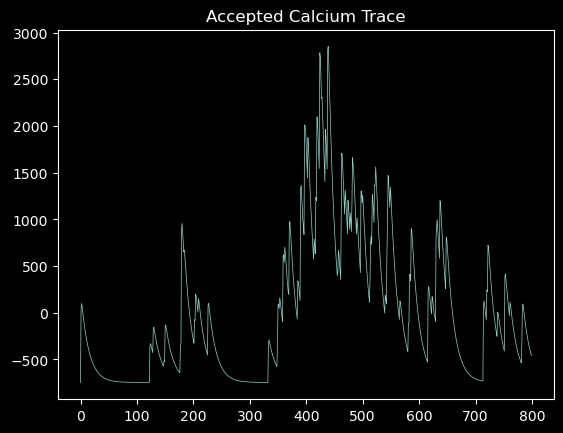

In [15]:
x = range(0, temporal_good.shape[1])
plt.plot(
    x,
    temporal_good[0, :],
    linewidth=0.5,
)
plt.title('Accepted Calcium Trace')

In [ ]:

x = range(0, temporal_good.shape[1])
plt.plot(
    x,
    temporal_good[0, :],
    linewidth=0.5,
)
plt.title('Rejected Calcium Trace')

In [32]:
df.iloc[index].cnmf.get_temporal(np.array([1, 5, 9]))
# get contours
contours = df.iloc[index].cnmf.get_contours()
print(f"contour 0 coordinates:\n\n{contours[0][0]}\n\n com: {contours[1][0]}")

contour 0 coordinates:

[[10.          6.13896887]
 [ 9.          6.37114421]
 [ 8.          6.72039797]
 [ 7.53453468  7.        ]
 [ 7.          7.45383068]
 [ 6.56759002  8.        ]
 [ 6.44461114  9.        ]
 [ 6.          9.4930009 ]
 [ 5.          9.64412601]
 [ 4.62678225 10.        ]
 [ 4.         10.46137997]
 [ 3.         10.65940104]
 [ 2.23051667 11.        ]
 [ 2.         11.21730325]
 [ 1.         11.85066966]
 [ 0.39663783 11.        ]
 [ 0.31556322 10.        ]
 [ 0.19150171  9.        ]
 [ 0.17622389  8.        ]
 [ 0.14595975  7.        ]
 [ 0.12719321  6.        ]
 [ 0.12018347  5.        ]
 [ 0.11680068  4.        ]
 [ 0.1134206   3.        ]
 [ 0.10339425  2.        ]
 [ 0.10673679  1.        ]
 [ 1.          0.10673679]
 [ 2.          0.13836192]
 [ 3.          0.16204505]
 [ 4.          0.20282491]
 [ 5.          0.3527411 ]
 [ 6.          0.47018696]
 [ 7.          0.58717071]
 [ 8.          0.6722471 ]
 [ 9.          0.88525457]
 [ 9.29169238  1.        ]
 [ 9

In [33]:
contours_good = df.iloc[index].cnmf.get_contours("good")
len(contours_good[0]) # number of contours

539

In [34]:
swap_dim_true = df.iloc[index].cnmf.get_contours()[0][0]
swap_dim_false = df.iloc[index].cnmf.get_contours(swap_dim=False)[0][0]

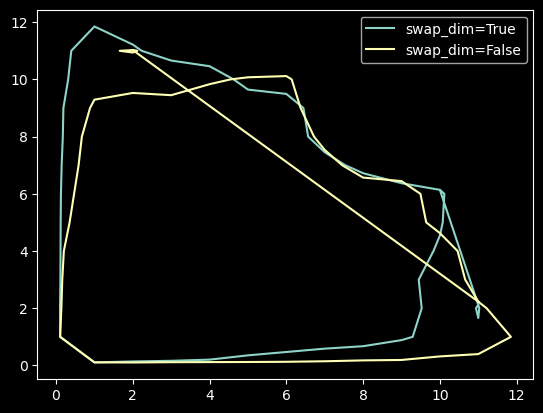

In [35]:
plt.plot(
    swap_dim_true[:, 0], 
    swap_dim_true[:, 1], 
    label="swap_dim=True"
)
plt.plot(
    swap_dim_false[:, 0], 
    swap_dim_false[:, 1], 
    label="swap_dim=False"
)
plt.legend()

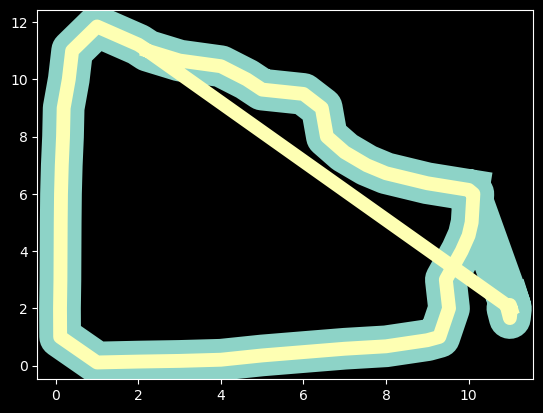

In [36]:
# swap_dim swaps the x and y dims
plt.plot(
    swap_dim_true[:, 0], 
    swap_dim_true[:, 1], 
    linewidth=30
)
plt.plot(
    swap_dim_false[:, 1], 
    swap_dim_false[:, 0], 
    linewidth=10
)

In [ ]:
from itertools import product

# variants of several parameters
# you can make lists for as many params as you want
K_variants = [None, 10]
merge_thr_variants = [0.6, 0.8, 0.9, 0.98]

# always use deepcopy like before
new_params_cnmf = deepcopy(params_cnmfe)

# create a parameter grid
# product is a nice way to create all combinations of multiple iterables like lists
parameter_grid = product(K_variants, merge_thr_variants)

# a single for loop to go through all the various parameter combinations
for K, merge_thr in parameter_grid:
    # deep copy params dict just like before
    new_params_cnmf = deepcopy(new_params_cnmf)
    
    # one set of parameter combinations
    new_params_cnmf["main"]["K"] = K
    new_params_cnmf["main"]["merge_thr"] = merge_thr
    
    # add param combination variant to batch
    df.caiman.add_item(
        algo="cnmfe",
        item_name=df.iloc[0]["item_name"],
        input_movie_path=df.iloc[0],
        params=new_params_cnmf
    )


In [37]:
rcm = df.iloc[index].cnmf.get_rcm()
rcm

LazyArrayRCM @0x7f1dbf893190
LazyArray for reconstructed movie, i.e. A ⊗ C
Frames are computed only upon indexing
shape [frames, x, y]: (800, 583, 544)
n_components: 1315

In [16]:
rcm_accepted = df.iloc[index].cnmf.get_rcm("good")
rcm_rejected = df.iloc[index].cnmf.get_rcm("bad")

In [17]:
import napari

viewer = napari.Viewer()
viewer.add_image(rcm_accepted, name='accepted')
viewer.add_image(rcm_rejected, name='rejected')

<Image layer 'rejected' at 0x7f42644c5950>